# Face Alignment

# Ваша часть:

## Архитектура Stacked Hourglass Network

**Hourglass** — это U-Net-подобная структура, которая сначала уменьшает разрешение изображения, затем восстанавливает его обратно. Такая структура напоминает по форме песочные часы (hourglass).

**Stacked Hourglass Network** состоит Hourglass-блоков, каждый из которых старается уточнять результат предыдущего. Несмотря на то, что она придумана в 2016 году, до сих пор используется во многих исследовательских проектах для задачи обнаружения ключевых точек.

![image](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-23_at_12.49.50_PM.png)

### Hourglass module

Посмотрим подробнее на структуру **отдельного Hourglass-блока**

![retrt](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-23_at_12.50.12_PM.png)

Каждый бокс в этой схеме - это Residual block, который отвечает за извлечение признаков на разных уровнях детализации (вспоминаем про ResNet). Причем, каждый такой блок иммеет одинаковую размерность на входе и на выходе.

Downsampling и upsampling можно делать разными способами.

*   Для Downsampling: nn.MaxPool2d или nn.Conv2d
*   Для Upsampling: nn.Upsample или nn.ConvTranspose2d

Основная разница: maxpool и upsample - необучаемые слои в отличие от сверток. Это может как быть как минусом, так и плюсом: чем больше параметров - тем медленее идет процесс обучения (при этом не факт, что результаты будут лучше).

То есть, идейно все практически также как было в U-net: полностью симметричная архитектура, сначала идет преобразование в более низкоразмерное пространство, а потом декодирование обратно с пробросами результатов из соотвествующих слоев энкодера. Разница лишь в том, что теперь каждый кирпичик - это Residual block.

А вот реализация ResidualBlock вам в помощь!

Но можете ее править под себя, если очень хочется.

In [2]:
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

#         self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
#         self.bn1 = nn.BatchNorm2d(out_channels // 2)
#         self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
#         self.bn2 = nn.BatchNorm2d(out_channels // 2)
#         self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
#         self.bn3 = nn.BatchNorm2d(out_channels)

#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, x):
#         residual = self.skip(x)
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.relu(self.bn2(self.conv2(x)))
#         x = self.bn3(self.conv3(x))
#         return self.relu(x + residual)

NameError: name 'nn' is not defined

При построении архитектуры Hourglass-блоков **не обязательно полностью повторять архитектуру**, которая представлена на картинке из статьи. Вы можете добавлять больше или меньше модулей, некоторые блоки вообще можно не использовать. В целом, это творческая задача и вы вольны делать так, как вам самим хочется. **Главное - чтобы ваша реализация соотвествовала изначальной идее Hourglass, и итоговые результаты были достаточно хорошими.**

### Stacked Hourglass Network

Как и было сказано ранее, Stacked Hourglass - это набор одинаковых Hourglass блоков (см. схематический рисунок в начале ноутбука). Но что это за блок между каждыми двумя Hourglass? Чтобы ответить на этот вопрос, нужно сначала разобраться с тем, что мы будем получать на выходе такой нейронной сети.

Предсказывать ключевые точки лица можно поразному. Есть два основных подхода:

1.   Регрессия - предсказывает координаты точек лица напрямую -> $(N, x, y)$.
2.   Heatmap - предсказывает карту вероятностей на выходе, а наиболее подходящие точки находятся через argmax

Не вдваясь в подробности, можно просто сказать, что Heatmap-подход показал себя лучше из-за своей устойчивости к шумам и начальным условиям. В качестве функции потерь в таком случае используют обычный **MSE loss**.

В Stacked Hourglass **используется именно heatmap-подход**. И на выходе каждого Hourglass-блока находится слой (голова), который создает heatmap нужного размера. Обычно это какие-то стандартные варианты по типу *Conv -> BatchNorm -> Relu -> Conv* или просто *Conv*. Каждая heatmap'a прокидывается на следующую голову, и они суммируются, и так, пока слои не закончатся.

Такой подход нужен для реализации **Intermediate Supervision**. Если говорить простыми словами, то это такой вариант обучения нейронной сети, когда мы подсчитываем лосс не только по финальному выходу сети, а также на некоторых промежуточных слоях (головах). Градиенты в этом случае тоже распространяются не только через последний выход, но и через промежуточные уровни. Эти головы не влияют на финальное предсказание напрямую, но помогают модели быстрее и лучше учиться. На практике это означет следующее:

Нужно посчитать лосс (таргет для всех одинаковый) для каждой головы отдельно, а потом просуммировать. Далее Pytorch сам построит за вас весь граф вычислений и правильно запустит везде градиенты. В коде это выглядит так:

```
outputs = model(image)  # outputs — список из N heatmaps от разных голов
losses = [loss_function(output, target) for output in outputs]
total_loss = sum(losses)
total_loss.backward()
optimizer.step()
```

Подведем **итоги по архитектуре**.

Stacked Hourglass состоит из Hourglass-блоков, после каждого такого блока идет голова, которая предсказывает heatmap'у. Каждая heatmap'а суммируется с предыдущей. Градиенты при обучении текут с каждой головы, а не только через последний выход сети.

Подробно про Stacked Hourglass Network можно прочитать в [оригинальной статье](https://arxiv.org/pdf/1603.06937).

## Датасет

Есть множество датасетов для этой задачи, но для наших целей должно хватить и [CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset). К сожалению или к счастью в разметке там всего 5 точек

1.   Левый глаз
2.   Правый глаз
3.   Нос
4.   Левый уголок рта
5.   Правый уголок рта


Единственная проблема заключается в том, что разметка - это именно точки, а не heatmap'ы. Но можно их сгенерировать самостоятельно при помощи гауссовского распределения вокруг размеченных точек. Вот вам функции в помощь. Можете их тоже редактивовать под себя, если нужно.

In [100]:
# import numpy as np

# def create_heatmap(size, landmark, sigma=2):
#     """
#     Создаёт один heatmap с гауссовым ядром вокруг точки.

#     :param size: (height, width) — размер heatmap'а
#     :param landmark:(x, y) — координаты точки
#     :param sigma
#     :return: heatmap массив
#     """
#     x, y = landmark
#     h, w = size

#     # Обрезаем координаты, чтобы не выйти за пределы изображения
#     x = min(max(0, int(x)), w - 1)
#     y = min(max(0, int(y)), h - 1)

#     xx, yy = np.meshgrid(np.arange(w), np.arange(h))
#     heatmap = np.exp(-((yy - y)**2 + (xx - x)**2) / (2 * sigma**2))
#     return heatmap


# def landmarks_to_heatmaps(image_shape, landmarks, sigma=2):
#     """
#     Преобразует список из N точек в набор из N heatmap'ов.

#     :param image_shape: исходный размер изображения (H, W)
#     :param landmarks: список из N пар координат [(x1, y1), (x2, y2), ..., (xN, yN),]
#     :param sigma:
#     :return: массив heatmap'ов вида [N, H, W]
#     """
#     heatmaps = []

#     for (x, y) in landmarks:
#         hm = create_heatmap(image_shape, (x, y), sigma=sigma)
#         heatmaps.append(hm)

#     return np.array(heatmaps)

Сам по себе CelebA избыточно большой для нашей задачи, поэтому можете использовать только его часть. Также, имеет смысл заранее кропнуть картинки таким образом, чтобы на них остались только лица, ну или по крайней мере минимум всего остального.

## Выравнивание по предсказанным точкам

Существует множество вариантов, как по полученным точкам правильно преобразовать картинку. Главное, что вам нужно понимать - **это задача классического компьютерного зрения** и решается при помощи математики, без нейронок. Вдаваться в подробности конкретных алгоритмов мы не будем.

Можно использовать аффинное преобразование, тогда потребуется только 3 точки, можно, например, искать матрицу гомографии, где может быть использовано больше точек, а может быть, есть еще что-то. Реализовывать эти алгоритмы самим не нужно. Достаточно провести небольшой ресерч и найти готовое решение (но **не готовую нейронку для выравнивания**), лишь бы оно работало. Количество используемых точек тоже выбирайте сами, подойдет любой вариант. Условный ориентир для поиска - библиотека **opencv**.

# План заданий

По итогу, в этом блоке у вас следующие задачи:


*   Реализовать Hourglass блок
*   Реализовать Stacked Hourglass
*   Подготовить датасет, преобразовав точки в Heatmap'ы
*   Обучить модель
*   Найти или реализовать функцию, которая бы по предсказанным ключевым точкам делала бы выравнивание лица на картинке (face alignment)

**P.S. Не забывайте сохранять модели после обучения и выводите промежуточные результаты на экран**



**Удачи! У вас всё получится 💗!**

# Моя часть

## Импорты

In [2]:
import os
import pandas as pd
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## Dataset class

In [3]:
landmarks_file='./celebA/list_landmarks_align_celeba.csv'
df = pd.read_csv(landmarks_file)

In [4]:
df.head(5)

image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  \
0  000001.jpg         69        109         106         113      77     142   
1  000002.jpg         69        110         107         112      81     135   
2  000003.jpg         76        112         104         106     108     128   
3  000004.jpg         72        113         108         108     101     138   
4  000005.jpg         66        114         112         112      86     119   

   leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
0           73          152           108           154  
1           70          151           108           153  
2           74          156            98           158  
3           71          155           101           151  
4           71          147           104           150

Возможно, у вас возникнет вопрос, почему классов два. Отвечаю: потому что я сперва делаю, а потом читаю задание дальше :В

#### Dataset with landmarks

In [17]:
# import os
# import pandas as pd
# from pathlib import Path
# from PIL import Image
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms
# import torch
# import numpy as np
# class CelebALandmarkDataset(Dataset):
#     def __init__(self, img_dir, landmarks_file, transform=None):
#         """
#         img_dir: Path to image folder, e.g. './celebA/img_align_celeba'
#         landmarks_file: Path to CSV with landmarks, e.g. './celebA/list_landmarks_align_celeba.csv'
#         transform: torchvision transform pipeline for images
#         """
#         self.img_dir = Path(img_dir)
#         self.transform = transform

#         # Read the CSV file with landmarks
#         df = pd.read_csv(landmarks_file)
#         # df.reset_index(inplace=True)
#         # df.rename(columns={'index': 'filename'}, inplace=True)

#         self.landmarks_df = df

#     def __len__(self):
#         return len(self.landmarks_df)

#     def __getitem__(self, idx):
#         row = self.landmarks_df.iloc[idx]
#         # print(row)
#         filename = row['image_id']
#         # print(filename)
#         img_path = self.img_dir / filename

#         # Load image
#         image = Image.open(img_path).convert('RGB')

#         # Extract landmarks and convert to tensor of shape (10,)
#         # Order: [lefteye_x, lefteye_y, righteye_x, ..., mouthright_y]
#         landmarks = row[1:].values.astype('float32')
#         landmarks = np.array([(landmarks[:2]), (landmarks[2:4]), 
#                      (landmarks[4:6]), (landmarks[6:8]),
#                      (landmarks[8:10])])
#         landmarks_tensor = torch.tensor(landmarks)  # shape (10,)

#         if self.transform:
#             image = self.transform(image)

#         return image, landmarks_tensor


In [18]:
# transform = transforms.Compose([
#     # transforms.Resize((256, 256)),
#     transforms.ToTensor(),  # (3, H, W)
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
# ])

# dataset = CelebALandmarkDataset(
#     img_dir='./celebA/img_align_celeba',
#     landmarks_file='./celebA/list_landmarks_align_celeba.csv',
#     transform=transform
# )

# dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# # Iterate one batch
# for images, landmarks in dataloader:
#     print(images.shape)      # torch.Size([32, 3, 256, 256])
#     print(landmarks.shape)   # torch.Size([32, 10])
#     break

torch.Size([4, 3, 218, 178])
torch.Size([4, 5, 2])


In [19]:
# import matplotlib.pyplot as plt
# import torchvision

# def show_landmarks_batch(images, landmarks, mean=[0.5]*3, std=[0.5]*3):
#     """
#     Visualizes a batch of images and landmarks.
#     images: tensor of shape (B, 3, H, W)
#     landmarks: tensor of shape (B, 10)
#     """
#     batch_size = images.shape[0]

#     # Unnormalize
#     images = images.clone()
#     for i in range(3):
#         images[:, i] = images[:, i] * std[i] + mean[i]
    
#     images = images.permute(0, 2, 3, 1).numpy()  # shape: (B, H, W, 3)

#     fig, axs = plt.subplots(1, batch_size, figsize=(16, 4))
#     for i in range(batch_size):
#         img = images[i]
#         lm = landmarks[i].reshape(-1, 2).numpy()

#         axs[i].imshow(img)
#         axs[i].scatter(lm[:, 0], lm[:, 1], c='red', s=20)
#         axs[i].axis('off')
#     plt.tight_layout()
#     plt.show()


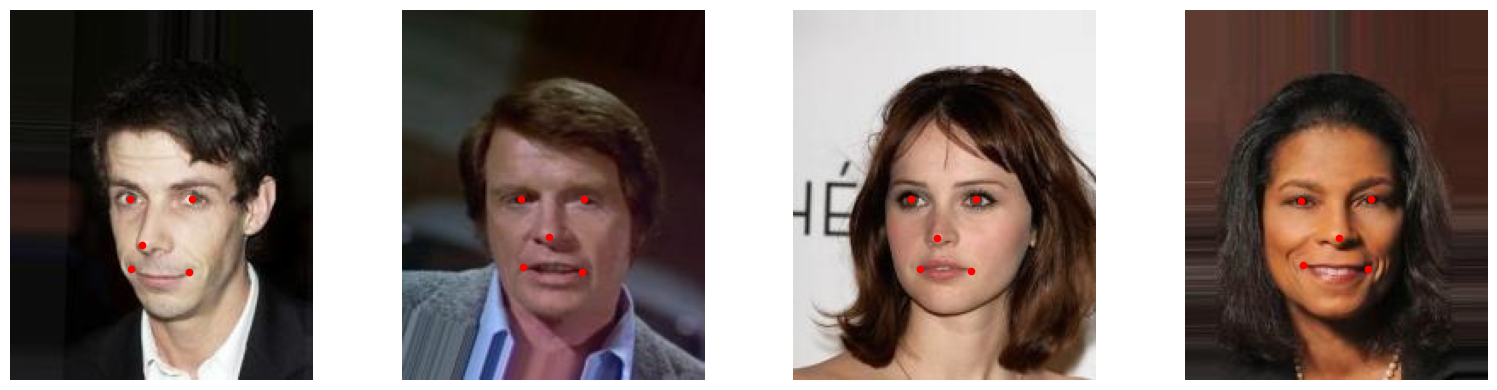

In [140]:
# # Get a batch
# images, landmarks = next(iter(dataloader))

# # Visualize
# show_landmarks_batch(images, landmarks)


#### Dataset with heatmaps

In [72]:
# --- Heatmap functions ---
def create_heatmap(size, landmark, sigma=2):
    x, y = landmark
    h, w = size
    x = min(max(0, int(x)), w - 1)
    y = min(max(0, int(y)), h - 1)
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    heatmap = np.exp(-((yy - y)**2 + (xx - x)**2) / (2 * sigma**2))
    return heatmap

def landmarks_to_heatmaps(image_shape, landmarks, sigma=2):
    heatmaps = [create_heatmap(image_shape, (x, y), sigma=sigma) for x, y in landmarks]
    return np.array(heatmaps)  # Shape: (N, H, W)

# --- Dataset class ---
class CelebALandmarkDataset(Dataset):
    def __init__(self, img_dir, landmarks_file, transform=None, heatmap_size=(256, 256), sigma=2, crop_size=96):
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.heatmap_size = heatmap_size  # final size after resizing crop
        self.sigma = sigma
        self.crop_size = crop_size  # e.g. 96

        df = pd.read_csv(landmarks_file)
        self.landmarks_df = df

        # CelebA aligned image size
        self.orig_h = 218
        self.orig_w = 178

    def __len__(self):
        return len(self.landmarks_df)

    def __getitem__(self, idx):
        row = self.landmarks_df.iloc[idx]
        filename = row['image_id']
        img_path = self.img_dir / filename

        # Load image (original size: 218×178)
        image = Image.open(img_path).convert('RGB')
        image_np = np.array(image)

        # Extract landmarks
        landmarks = row[1:].values.astype('float32').reshape(-1, 2)

        # === CROP around nose point ===
        nose_x, nose_y = landmarks[2]  # (index 2) is nose
        crop_half = self.crop_size // 2
        left = int(nose_x - crop_half)
        top = int(nose_y - crop_half)
        right = left + self.crop_size
        bottom = top + self.crop_size

        # Clamp crop box to image bounds
        left = max(0, min(left, self.orig_w - self.crop_size))
        top = max(0, min(top, self.orig_h - self.crop_size))
        right = left + self.crop_size
        bottom = top + self.crop_size

        # Crop image
        cropped = image_np[top:bottom, left:right, :]  # shape (96, 96, 3)
        cropped_image = Image.fromarray(cropped).resize(tuple(4*x for x in self.heatmap_size), Image.BILINEAR)

        # Adjust landmarks to cropped+resized coordinates
        adjusted_landmarks = []
        for x, y in landmarks:
            x_new = (x - left) * (self.heatmap_size[1] / self.crop_size)
            y_new = (y - top) * (self.heatmap_size[0] / self.crop_size)
            adjusted_landmarks.append((x_new, y_new))

        # Generate heatmaps
        heatmaps = landmarks_to_heatmaps(self.heatmap_size, adjusted_landmarks, sigma=self.sigma)
        heatmaps_tensor = torch.tensor(heatmaps, dtype=torch.float32)

        # Apply transform to image (e.g., ToTensor, Normalize)
        if self.transform:
            cropped_image = self.transform(cropped_image)

        return cropped_image, heatmaps_tensor

In [73]:
transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.ToTensor(),  # (3, H, W)
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

dataset = CelebALandmarkDataset(
    img_dir='./celebA/img_align_celeba',
    landmarks_file='./celebA/list_landmarks_align_celeba.csv',
    transform=transform,
    crop_size=112,
    # heatmap_size=(218,178)
    heatmap_size=(64, 64)
)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Iterate one batch
for images, landmarks in dataloader:
    print(images.shape)      # torch.Size([32, 3, 256, 256])
    print(landmarks.shape)   # torch.Size([32, 10])
    break

torch.Size([4, 3, 256, 256])
torch.Size([4, 5, 64, 64])


In [74]:
import matplotlib.pyplot as plt

def show_heatmaps_batch(images, heatmaps, mean=[0.5]*3, std=[0.5]*3):
    """
    Visualizes a batch of images and their landmark heatmaps (max over keypoints).
    images: tensor (B, 3, H, W)
    heatmaps: tensor (B, num_keypoints, H, W)
    """
    batch_size = images.shape[0]

    # Unnormalize images
    images = images.clone()
    for i in range(3):
        images[:, i] = images[:, i] * std[i] + mean[i]

    images = images.permute(0, 2, 3, 1).numpy()  # B, H, W, 3
    heatmaps = heatmaps.numpy()  # B, N, H, W

    fig, axs = plt.subplots(1, batch_size, figsize=(16, 4))
    for i in range(batch_size):
        img = images[i]
        hm = heatmaps[i].max(axis=0)  # collapse to single-channel heatmap

        axs[i].imshow(img)
        axs[i].imshow(hm, alpha=0.5, cmap='jet')  # overlay heatmap
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


In [76]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def show_heatmaps_batch(images, heatmaps, mean=[0.5]*3, std=[0.5]*3):
    """
    Visualizes a batch of images and their upsampled landmark heatmaps.
    
    Args:
        images: Tensor of shape (B, 3, H, W) — input images.
        heatmaps: Tensor of shape (B, num_keypoints, h, w) — heatmaps to overlay.
        mean, std: Normalization parameters for unnormalization.
    """
    batch_size = images.shape[0]
    img_height, img_width = images.shape[2:]

    # Unnormalize images
    images = images.clone()
    for i in range(3):
        images[:, i] = images[:, i] * std[i] + mean[i]
    images = images.permute(0, 2, 3, 1).cpu().numpy()  # B, H, W, 3

    # Upsample heatmaps to match image size
    upsampled_heatmaps = F.interpolate(heatmaps, size=(img_height, img_width), mode='bilinear', align_corners=False)
    upsampled_heatmaps = upsampled_heatmaps.cpu().numpy()  # B, N, H, W

    fig, axs = plt.subplots(1, batch_size, figsize=(16, 4))
    for i in range(batch_size):
        img = images[i]
        hm = upsampled_heatmaps[i].max(axis=0)  # collapse to single-channel heatmap

        axs[i].imshow(img)
        axs[i].imshow(hm, alpha=0.5, cmap='jet')  # overlay heatmap
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


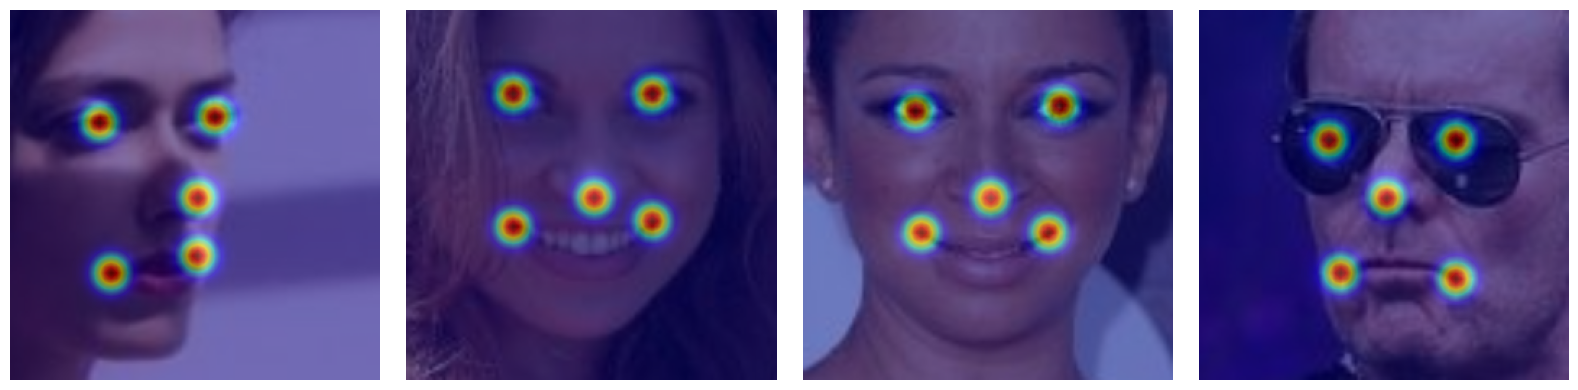

In [77]:
# Dataloader from your dataset
for images, heatmaps in dataloader:
    show_heatmaps_batch(images, heatmaps)
    break


## Das Model

In [78]:
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [215]:
# взят без изменений
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

In [259]:
# Hourglass Module: 3 down, 2 bottlenecks, 3 up with skip connections
class HourglassModule(nn.Module):
    def __init__(self, num_channels):
        super().__init__()

        self.down1 = ResidualBlock(num_channels, num_channels)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = ResidualBlock(num_channels, num_channels)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = ResidualBlock(num_channels, num_channels)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck1 = ResidualBlock(num_channels, num_channels)
        self.bottleneck2 = ResidualBlock(num_channels, num_channels)

        self.up3 = ResidualBlock(num_channels, num_channels)
        self.up2 = ResidualBlock(num_channels, num_channels)
        self.up1 = ResidualBlock(num_channels, num_channels)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        x1 = self.down1(x)  # skip 1
        x2 = self.pool1(x1)

        x2 = self.down2(x2)  # skip 2
        x3 = self.pool2(x2)

        x3 = self.down3(x3)  # skip 3
        x4 = self.pool3(x3)

        x4 = self.bottleneck1(x4)
        x4 = self.bottleneck2(x4)

        x4 = self.upsample3(x4)
        x4 = self.up3(x4 + x3)  # skip 3

        x4 = self.upsample2(x4)
        x4 = self.up2(x4 + x2)  # skip 2

        x4 = self.upsample1(x4)
        x4 = self.up1(x4 + x1)  # skip 1

        return x4


In [37]:
class HeatmapHead(nn.Module):
    def __init__(self, in_channels, num_keypoints):
        super().__init__()
        self.head = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, num_keypoints, kernel_size=1)  # final output
        )

    def forward(self, x):
        return self.head(x)  # shape: [B, num_keypoints, H, W]


In [39]:
class StackedHourglassNet(nn.Module):
    def __init__(self, in_channels=3, num_channels=128, num_keypoints=5, num_stacks=3):
        super().__init__()
        self.num_stacks = num_stacks

        # Downsample input to 64x64 as per original paper
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, num_channels, kernel_size=7, stride=2, padding=3),  # 256 -> 128
            nn.BatchNorm2d(num_channels),
            nn.ReLU(inplace=True),
            ResidualBlock(num_channels, num_channels),
            nn.MaxPool2d(2),  # 128 -> 64
            ResidualBlock(num_channels, num_channels),
            ResidualBlock(num_channels, num_channels)
        )

        self.hourglasses = nn.ModuleList([
            HourglassModule(num_channels) for _ in range(num_stacks)
        ])
        self.intermediate_heads = nn.ModuleList([
            HeatmapHead(num_channels, num_keypoints) for _ in range(num_stacks)
        ])

        self.intermediate_features = nn.ModuleList([
            nn.Conv2d(num_keypoints, num_channels, kernel_size=1)
            for _ in range(num_stacks - 1)
        ])

    def forward(self, x):
        x = self.stem(x)
        outputs = []

        for i in range(self.num_stacks):
            hg = self.hourglasses[i](x)
            heatmap = self.intermediate_heads[i](hg)
            outputs.append(heatmap)

            if i < self.num_stacks - 1:
                x = x + self.intermediate_features[i](heatmap)

        return outputs  # list of heatmaps [B, K, H, W]

In [97]:
model = StackedHourglassNet(in_channels=3, num_channels=128, num_keypoints=5).to(DEVICE)

In [216]:
input_tensor, gt_heatmaps = next(iter(dataloader))
output_heatmaps = model(input_tensor.to(DEVICE))      # shape: (4, 5, 256, 256)
print(input_tensor.shape)
print(output_heatmaps[0].shape)

torch.Size([4, 3, 256, 256])
torch.Size([4, 5, 64, 64])


In [82]:
import matplotlib.pyplot as plt

def visualize_predictions(images, gt, heatmaps, mean=[0.5]*3, std=[0.5]*3):
    """
    images: Tensor (B, 3, H, W)
    heatmaps: Tensor (B, num_keypoints, H, W)
    """
    B = images.shape[0]
    images = images.clone()
    for i in range(3):
        images[:, i] = images[:, i] * std[i] + mean[i]
    images = images.permute(0, 2, 3, 1).cpu().numpy()
    heatmaps = heatmaps.detach().cpu().numpy()

    fig, axs = plt.subplots(1, B, figsize=(16, 4))
    for i in range(B):
        img = images[i]
        hm = heatmaps[i].max(axis=0)  # max over keypoints
        axs[i].imshow(img)
        axs[i].imshow(hm, alpha=0.5, cmap='jet')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()


In [88]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def show_heatmaps_batch(images, heatmaps, mean=[0.5]*3, std=[0.5]*3):
    """
    Visualizes a batch of images and their upsampled landmark heatmaps.
    
    Args:
        images: Tensor of shape (B, 3, H, W) — input images.
        heatmaps: Tensor of shape (B, num_keypoints, h, w) — heatmaps to overlay.
        mean, std: Normalization parameters for unnormalization.
    """
    batch_size = images.shape[0]
    img_height, img_width = images.shape[2:]

    # Unnormalize images
    images = images.clone()
    for i in range(3):
        images[:, i] = images[:, i] * std[i] + mean[i]
    images = images.permute(0, 2, 3, 1).cpu().numpy()  # B, H, W, 3

    # Upsample heatmaps to match image size
    upsampled_heatmaps = F.interpolate(heatmaps, size=(img_height, img_width), mode='bilinear', align_corners=False)
    upsampled_heatmaps = upsampled_heatmaps.cpu().numpy()  # B, N, H, W

    fig, axs = plt.subplots(1, batch_size, figsize=(16, 4))
    for i in range(batch_size):
        img = images[i]
        hm = upsampled_heatmaps[i].max(axis=0)  # collapse to single-channel heatmap

        axs[i].imshow(img)
        axs[i].imshow(hm, alpha=0.5, cmap='jet')  # overlay heatmap
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


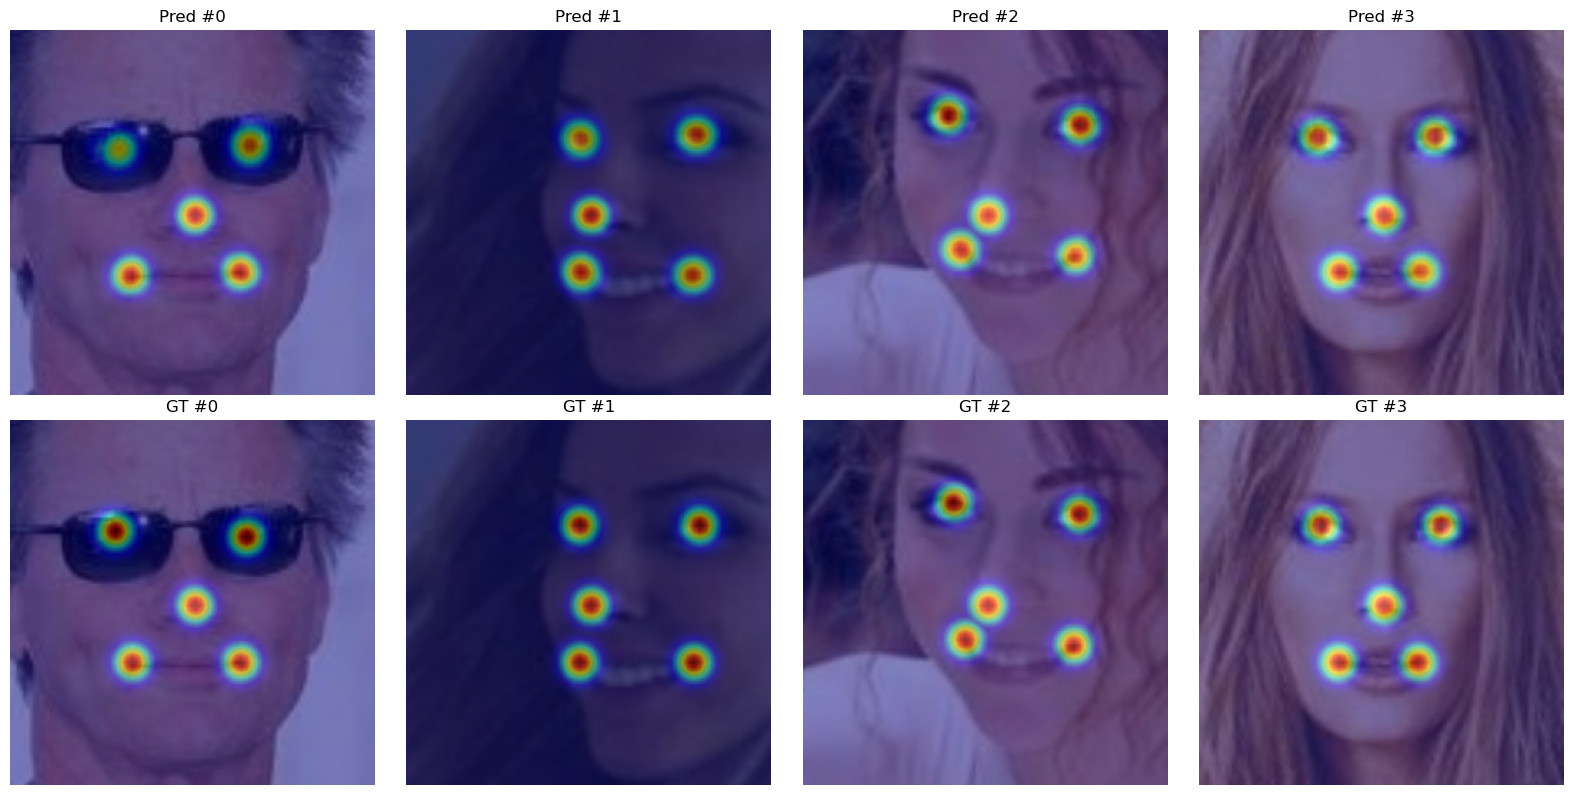

In [217]:
visualize_predictions(input_tensor, gt_heatmaps, output_heatmaps[2])

In [90]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

def heatmaps_to_keypoints(heatmaps, upsampled_size=None):
    """
    Converts heatmaps to keypoint (x, y) coordinates.

    Args:
        heatmaps: Tensor of shape (B, K, H, W)
        upsampled_size: (H_out, W_out) if you want to interpolate first

    Returns:
        coords: Tensor of shape (B, K, 2) — for each keypoint (x, y)
    """
    if upsampled_size is not None:
        heatmaps = F.interpolate(heatmaps, size=upsampled_size, mode='bilinear', align_corners=False)

    B, K, H, W = heatmaps.shape
    heatmaps = heatmaps.view(B, K, -1)
    indices = heatmaps.argmax(dim=2)

    y = indices // W
    x = indices % W
    coords = torch.stack((x, y), dim=2)
    return coords


def visualize_keypoints(images, gt_heatmaps, pred_heatmaps, mean=[0.5]*3, std=[0.5]*3):
    """
    Visualize predicted and ground-truth keypoints with keypoint indices.
    Automatically upsamples heatmaps to match image size before decoding.

    Args:
        images: Tensor of shape (B, 3, H, W)
        gt_heatmaps: Tensor of shape (B, K, h, w)
        pred_heatmaps: Tensor of shape (B, K, h, w)
    """
    B, _, img_H, img_W = images.shape

    # Upsample and decode keypoints
    pred_kpts = heatmaps_to_keypoints(pred_heatmaps, upsampled_size=(img_H, img_W)).cpu().numpy()
    gt_kpts = heatmaps_to_keypoints(gt_heatmaps, upsampled_size=(img_H, img_W)).cpu().numpy()

    # Unnormalize images
    images = images.clone().cpu()
    for i in range(3):
        images[:, i] = images[:, i] * std[i] + mean[i]
    images = images.permute(0, 2, 3, 1).numpy()

    fig, axs = plt.subplots(2, B, figsize=(4 * B, 8))

    for i in range(B):
        img = images[i]
        pred = pred_kpts[i]
        gt = gt_kpts[i]

        # Prediction
        axs[0, i].imshow(img)
        axs[0, i].scatter(pred[:, 0], pred[:, 1], c='lime', s=20)
        for j, (x, y) in enumerate(pred):
            axs[0, i].text(x + 2, y - 2, str(j), color='black', fontsize=12, weight='bold')
        axs[0, i].set_title(f'Prediction #{i}')
        axs[0, i].axis('off')

        # Ground truth
        axs[1, i].imshow(img)
        axs[1, i].scatter(gt[:, 0], gt[:, 1], c='red', s=20)
        for j, (x, y) in enumerate(gt):
            axs[1, i].text(x + 2, y - 2, str(j), color='pink', fontsize=12, weight='bold')
        axs[1, i].set_title(f'Ground Truth #{i}')
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()


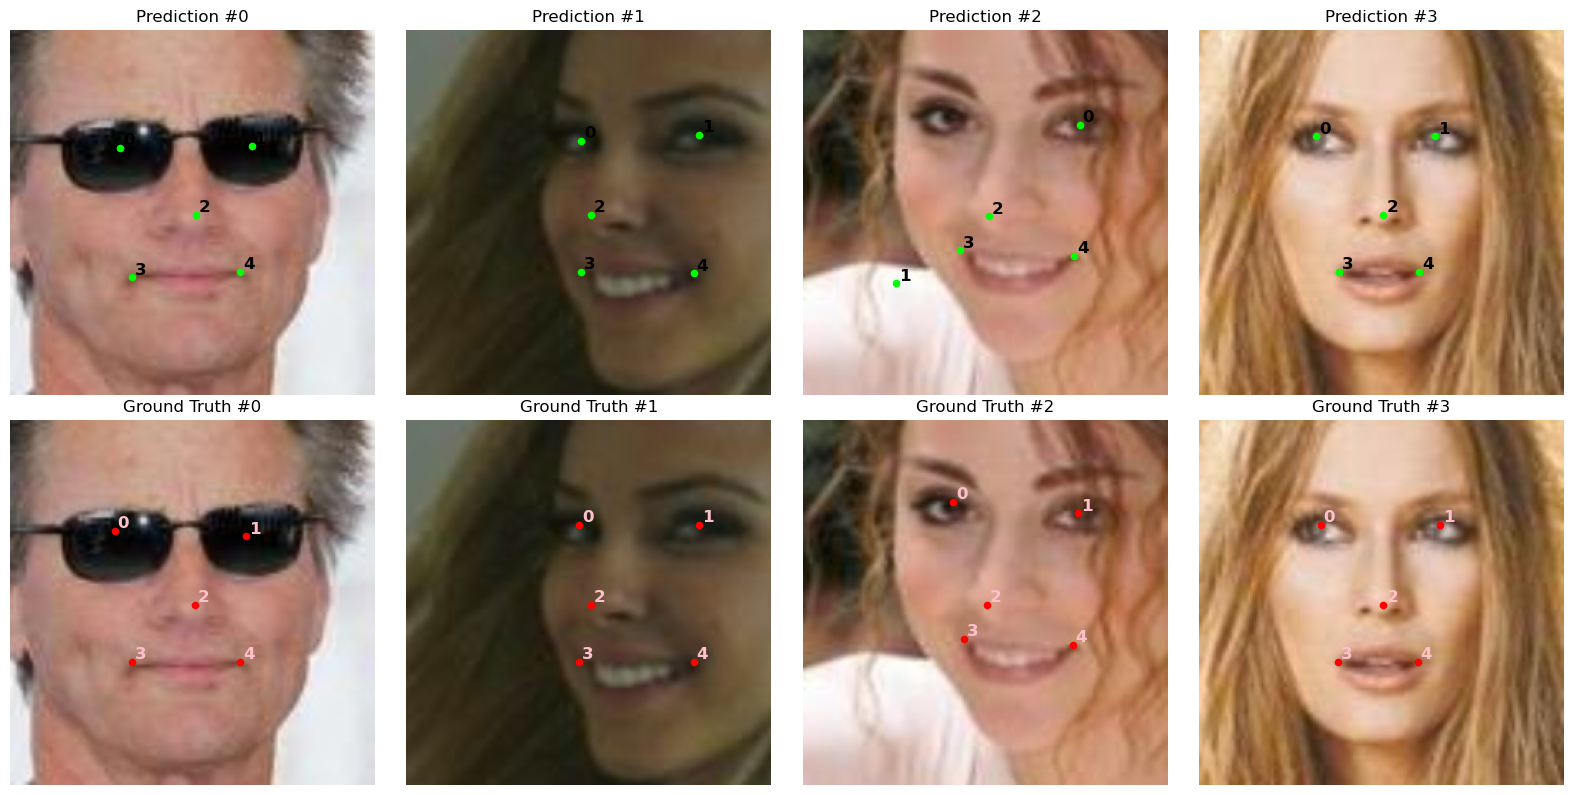

In [218]:
visualize_keypoints(input_tensor, gt_heatmaps, output_heatmaps[2])

## Training

In [47]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    processed_data = 0

    for inputs, heatmaps in train_loader:
        inputs = inputs.to(DEVICE)
        heatmaps = heatmaps.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = sum(criterion(out, heatmaps) for out in outputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    return train_loss


In [48]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    processed_data = 0

    with torch.no_grad():
        for inputs, heatmaps in val_loader:
            inputs = inputs.to(DEVICE)
            heatmaps = heatmaps.to(DEVICE)

            outputs = model(inputs)
            # loss = criterion(outputs, heatmaps)
            loss = sum(criterion(out, heatmaps) for out in outputs)

            running_loss += loss.item() * inputs.size(0)
            processed_data += inputs.size(0)

    val_loss = running_loss / processed_data
    return val_loss


In [49]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    history = []
    log_template = "\nEpoch {ep:03d} | train_loss: {t_loss:.4f} | val_loss: {v_loss:.4f}"

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, optimizer)
            scheduler.step()
            val_loss = eval_epoch(model, val_loader, criterion)

            history.append((train_loss, val_loss))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))

    return history


In [101]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataset_tiny, _ = torch.utils.data.random_split(train_dataset, [0.2, 0.8])
val_dataset_tiny, _ = torch.utils.data.random_split(val_dataset, [0.2, 0.8])

In [102]:
from tqdm.notebook import tqdm
history = train(train_dataset_tiny, val_dataset_tiny, model=model, epochs=20, batch_size=20)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 001 | train_loss: 0.0111 | val_loss: 0.0031

Epoch 002 | train_loss: 0.0020 | val_loss: 0.0014

Epoch 003 | train_loss: 0.0012 | val_loss: 0.0011

Epoch 004 | train_loss: 0.0010 | val_loss: 0.0010

Epoch 005 | train_loss: 0.0008 | val_loss: 0.0009

Epoch 006 | train_loss: 0.0007 | val_loss: 0.0007

Epoch 007 | train_loss: 0.0007 | val_loss: 0.0007

Epoch 008 | train_loss: 0.0007 | val_loss: 0.0007

Epoch 009 | train_loss: 0.0006 | val_loss: 0.0007

Epoch 010 | train_loss: 0.0006 | val_loss: 0.0007

Epoch 011 | train_loss: 0.0006 | val_loss: 0.0007

Epoch 012 | train_loss: 0.0006 | val_loss: 0.0007

Epoch 013 | train_loss: 0.0006 | val_loss: 0.0007

Epoch 014 | train_loss: 0.0006 | val_loss: 0.0007

Epoch 015 | train_loss: 0.0006 | val_loss: 0.0007

Epoch 016 | train_loss: 0.0006 | val_loss: 0.0007

Epoch 017 | train_loss: 0.0006 | val_loss: 0.0007

Epoch 018 | train_loss: 0.0006 | val_loss: 0.0007

Epoch 019 | train_loss: 0.0006 | val_loss: 0.0007

Epoch 020 | train_loss: 0.0006

In [219]:
# Define the path to save the state_dict
PATH = "my_SHG.pth"

# Save the model's state_dict
torch.save(model.state_dict(), PATH)

## Validation

In [231]:
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

In [234]:
input_tensor, gt_heatmaps = next(iter(val_dataloader))
output_heatmaps = model(input_tensor.to(DEVICE))      # shape: (4, 5, 256, 256)
print(input_tensor.shape)
print(output_heatmaps[0].shape)

torch.Size([4, 3, 256, 256])
torch.Size([4, 5, 64, 64])


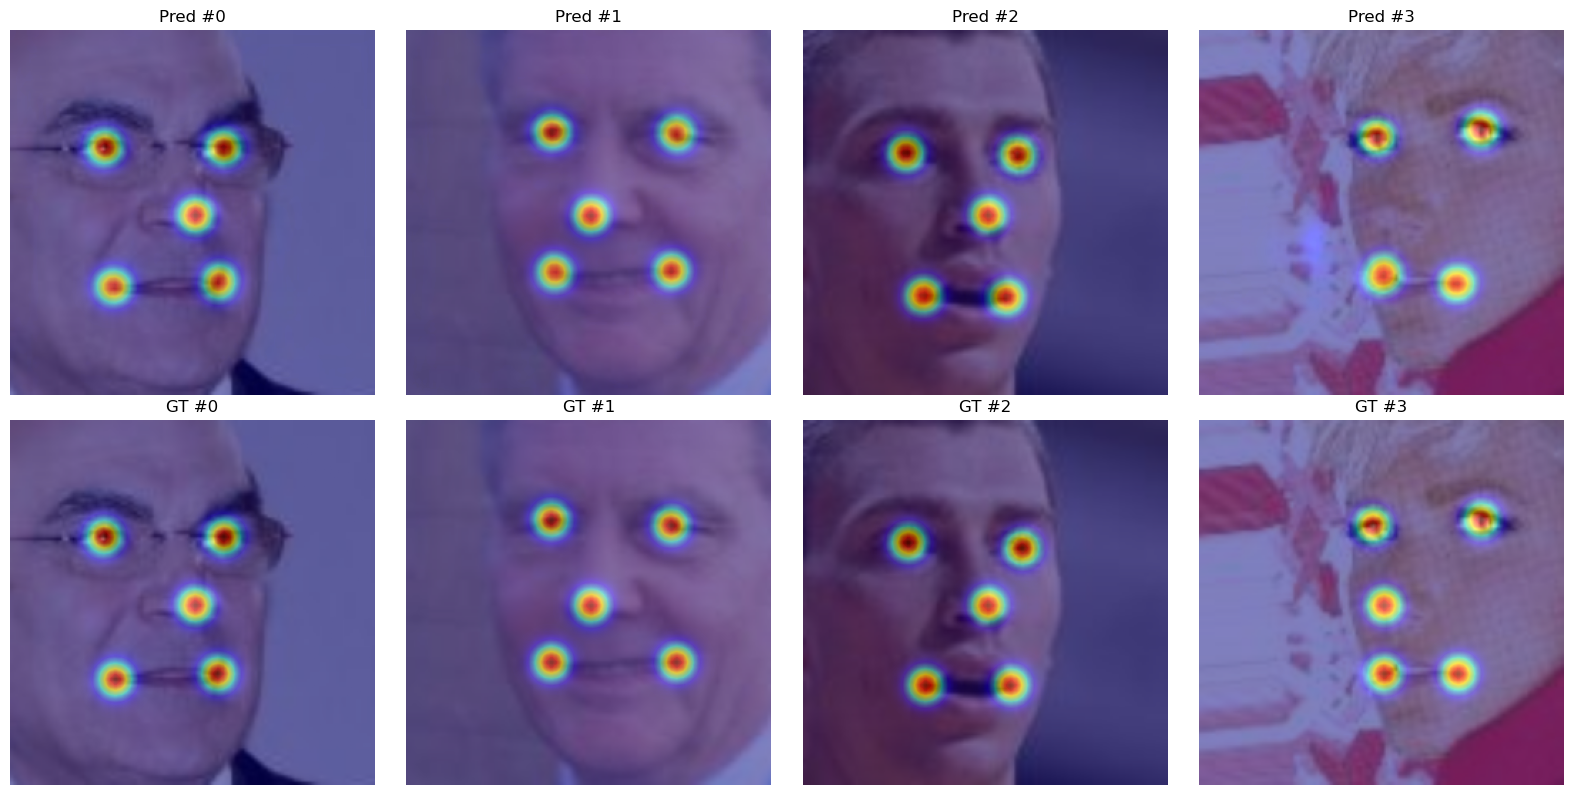

In [235]:
visualize_predictions(input_tensor, gt_heatmaps, output_heatmaps[2])

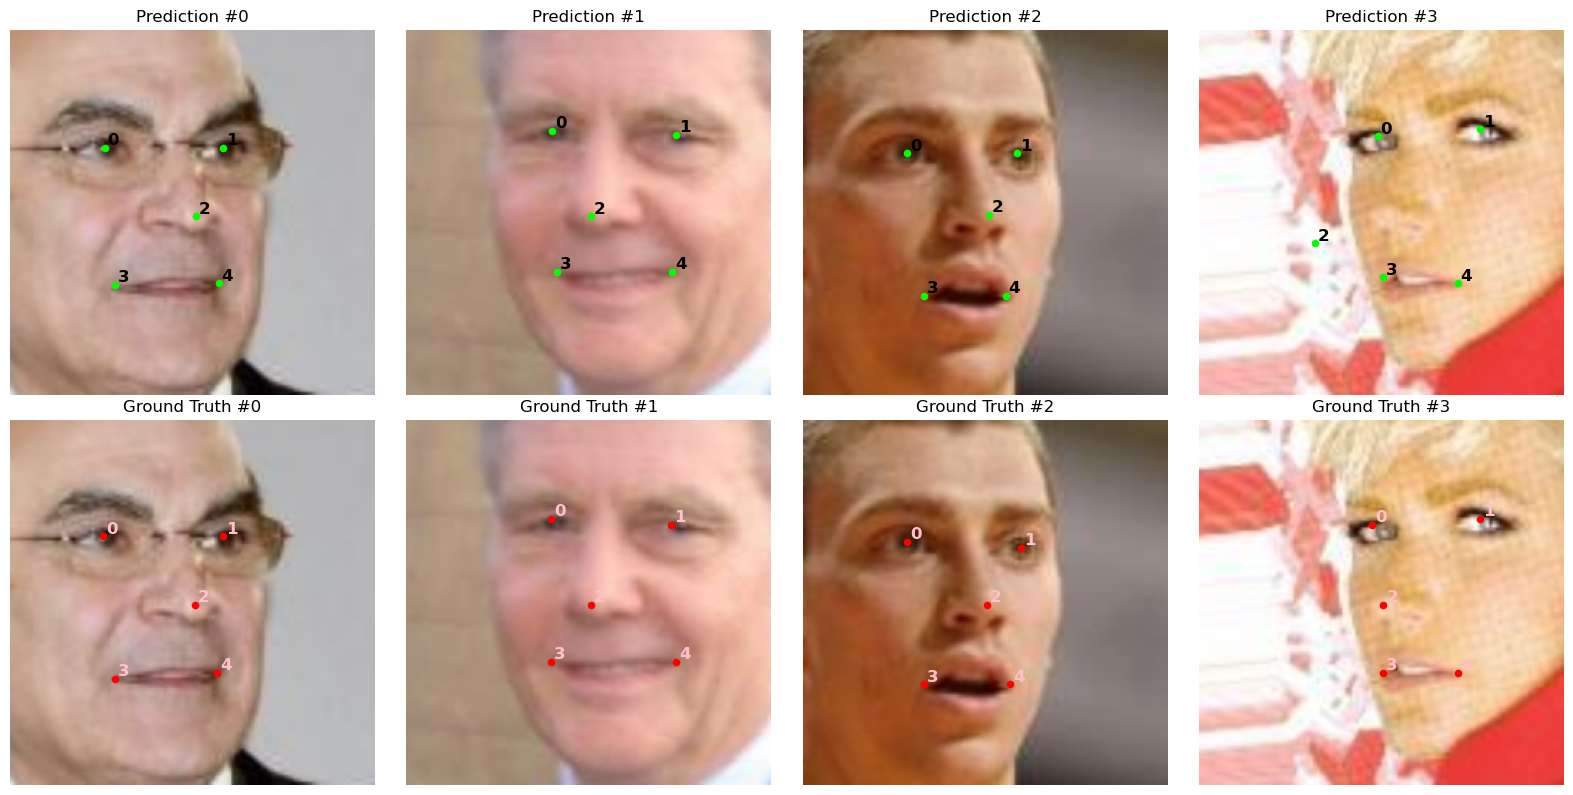

In [236]:
visualize_keypoints(input_tensor, gt_heatmaps, output_heatmaps[2])

## Alignment

In [114]:
import cv2

In [237]:
givi = cv2.imread("givi.png")
givi = cv2.cvtColor(givi, cv2.COLOR_BGR2RGB)

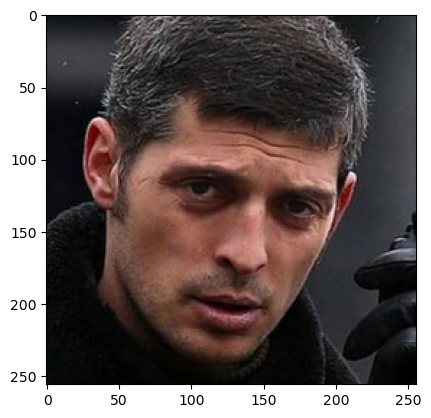

In [238]:
plt.imshow(givi)

In [239]:
givi_tensor = transforms.ToTensor()(givi).unsqueeze(0).to(DEVICE)
givi_tensor_norm = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(givi_tensor)

In [240]:
givi_tensor_norm.shape

torch.Size([1, 3, 256, 256])

In [241]:
output_heatmaps = model(givi_tensor_norm)
print(givi_tensor_norm.shape)
print(output_heatmaps[0].shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 5, 64, 64])


In [242]:
pred_kpts = heatmaps_to_keypoints(output_heatmaps[0], upsampled_size=(256,256))
pred_kpts = pred_kpts.detach().cpu().squeeze(0)
pred_kpts

tensor([[106, 118],
        [170, 133],
        [146, 162],
        [ 98, 197],
        [150, 202]])

In [243]:
def visualize_keypoints_single_image(image, pred_heatmap, mean=[0.5]*3, std=[0.5]*3, eye_indices=(0, 1)):
    """
    Visualize keypoints and a line between eyes for a single image.

    Args:
        image: Tensor of shape (3, H, W)
        pred_heatmap: Tensor of shape (K, h, w)
        eye_indices: indices of the two eye keypoints (default: (0, 1))
    """
    image = image.clone().unsqueeze(0)  # add batch dim
    pred_heatmap = pred_heatmap.unsqueeze(0)  # add batch dim
    _, _, img_H, img_W = image.shape

    # Decode keypoints
    pred_kpts = heatmaps_to_keypoints(pred_heatmap, upsampled_size=(img_H, img_W))[0].cpu().numpy()

    # Unnormalize image
    for i in range(3):
        image[:, i] = image[:, i] * std[i] + mean[i]
    img = image.squeeze().permute(1, 2, 0).cpu().numpy()

    # Plot
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img)
    ax.scatter(pred_kpts[:, 0], pred_kpts[:, 1], c='lime', s=30)

    # Annotate keypoints
    for j, (x, y) in enumerate(pred_kpts):
        ax.text(x + 2, y - 2, str(j), color='pink', fontsize=12, weight='bold')

    # Draw eye line
    x0, y0 = pred_kpts[eye_indices[0]]
    x1, y1 = pred_kpts[eye_indices[1]]
    ax.plot([x0, x1], [y0, y1], color='cyan', linewidth=2)

    ax.set_title("Predicted Keypoints + Eye Line")
    ax.axis('off')
    plt.show()

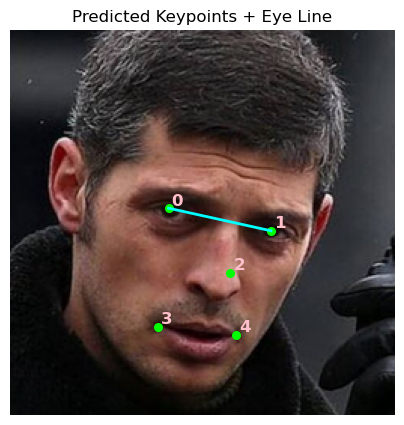

In [244]:
visualize_keypoints_single_image(givi_tensor_norm[0], output_heatmaps[2][0])

In [245]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import rotate as tv_rotate
import torch.nn.functional as F
import torchvision.transforms.functional as t_F

def compute_rotation_angle(pt1, pt2):
    """
    Computes angle (in degrees) between two points.
    """
    dy = pt2[1] - pt1[1]
    dx = pt2[0] - pt1[0]
    angle_rad = np.arctan2(dy, dx)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

def rotate_image_and_keypoints(image, keypoints, angle, center=None):
    """
    Rotates image and keypoints around a center.

    image: torch.Tensor (3, H, W)
    keypoints: torch.Tensor (K, 2) - (x, y)
    angle: in degrees (positive => counter-clockwise)
    center: (x, y) rotation center; defaults to image center

    Returns: rotated_image, rotated_keypoints
    """
    _, H, W = image.shape
    if center is None:
        center = (W / 2, H / 2)

    # Rotate image
    rotated_image = t_F.rotate(image, angle=angle, center=center, interpolation=t_F.InterpolationMode.BILINEAR)

    # Prepare rotation matrix
    angle_rad = -angle * np.pi / 180.0
    rot_matrix = torch.tensor([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad),  np.cos(angle_rad)]
    ], dtype=torch.float32)

    # Translate keypoints to origin -> rotate -> translate back
    kp_shifted = keypoints - torch.tensor(center)
    kp_rotated = torch.matmul(kp_shifted, rot_matrix.T) + torch.tensor(center)

    return rotated_image, kp_rotated


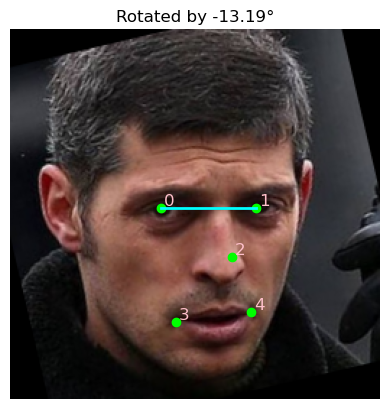

In [246]:
# Assume you have: 
# - image: torch.Tensor (3, H, W)
# - pred_kpts: torch.Tensor (K, 2) with keypoints in image coordinates
# Eyes are at index 0 and 1
eye0 = pred_kpts[0]
eye1 = pred_kpts[1]

# 1. Compute rotation angle
angle = compute_rotation_angle(eye0.numpy(), eye1.numpy())

# 2. Rotate image and keypoints
rotated_image, rotated_kpts = rotate_image_and_keypoints(givi_tensor[0], pred_kpts, angle)

# 3. Visualize
plt.imshow(rotated_image.permute(1, 2, 0).cpu().numpy())
plt.scatter(rotated_kpts[:, 0] , rotated_kpts[:, 1], c='lime')
for i, (x, y) in enumerate(rotated_kpts):
    plt.text(x + 2, y - 2, str(i), color='pink', fontsize=12)

x0, y0 = rotated_kpts[0]
x1, y1 = rotated_kpts[1]
plt.plot([x0, x1], [y0, y1], color='cyan', linewidth=2)

plt.title(f"Rotated by {-angle:.2f}°")
plt.axis('off')
plt.show()

### Соберём это всё в одну функцию

In [257]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.functional as tF
import torch.nn.functional as F

@torch.no_grad()
def align_face_and_plot(image_path, model, device='cuda', eye_indices=(0, 1), mean=[0.5]*3, std=[0.5]*3):
    model.eval()
    basename, ext = os.path.splitext(image_path)
    aligned_path = f"{basename}_aligned{ext}"

    # --- Load & preprocess ---
    orig_bgr = cv2.imread(image_path)
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
    orig_tensor = transforms.ToTensor()(orig_rgb).to(device)  # (3, H, W)
    norm_tensor = transforms.Normalize(mean, std)(orig_tensor.unsqueeze(0))  # (1, 3, H, W)

    # --- Predict keypoints ---
    heatmaps = model(norm_tensor)[-1]  # (1, K, h, w)
    pred_kpts = heatmaps_to_keypoints(heatmaps, upsampled_size=orig_tensor.shape[1:])[0].cpu()  # (K, 2)

    # --- Compute rotation angle & align ---
    eye0, eye1 = pred_kpts[eye_indices[0]], pred_kpts[eye_indices[1]]
    angle = compute_rotation_angle(eye0.numpy(), eye1.numpy())
    aligned_tensor, aligned_kpts = rotate_image_and_keypoints(orig_tensor, pred_kpts, angle)

    # --- Save aligned image ---
    aligned_np = (aligned_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    aligned_bgr = cv2.cvtColor(aligned_np, cv2.COLOR_RGB2BGR)
    cv2.imwrite(aligned_path, aligned_bgr)

    # --- Unnormalize for visualization ---
    def unnorm(img_t):
        out = img_t.clone()
        for i in range(3):
            out[i] = out[i] * std[i] + mean[i]
        return out.clamp(0, 1)

    aligned_vis = aligned_tensor.permute(1, 2, 0).cpu().numpy()

    # --- Plotting ---
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()

    # 1. Original
    axs[0].imshow(orig_rgb)
    axs[0].set_title("Original")
    axs[0].axis('off')

    # 2. Original + keypoints
    axs[1].imshow(orig_rgb)
    axs[1].scatter(pred_kpts[:, 0], pred_kpts[:, 1], c='lime', s=30)
    for j, (x, y) in enumerate(pred_kpts):
        axs[1].text(x + 2, y - 2, str(j), color='pink', fontsize=10)
    x0, y0 = eye0
    x1, y1 = eye1
    axs[1].plot([x0, x1], [y0, y1], color='cyan', linewidth=2)
    axs[1].set_title("Original + Keypoints")
    axs[1].axis('off')

    # 3. Aligned
    axs[2].imshow(aligned_vis)
    axs[2].set_title("Aligned")
    axs[2].axis('off')

    # 4. Aligned + keypoints
    axs[3].imshow(aligned_vis)
    axs[3].scatter(aligned_kpts[:, 0], aligned_kpts[:, 1], c='lime', s=30)
    for j, (x, y) in enumerate(aligned_kpts):
        axs[3].text(x + 2, y - 2, str(j), color='pink', fontsize=10)
    x0, y0 = aligned_kpts[eye_indices[0]]
    x1, y1 = aligned_kpts[eye_indices[1]]
    axs[3].plot([x0, x1], [y0, y1], color='cyan', linewidth=2)
    axs[3].set_title("Aligned + Keypoints")
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Aligned image saved to: {aligned_path}")


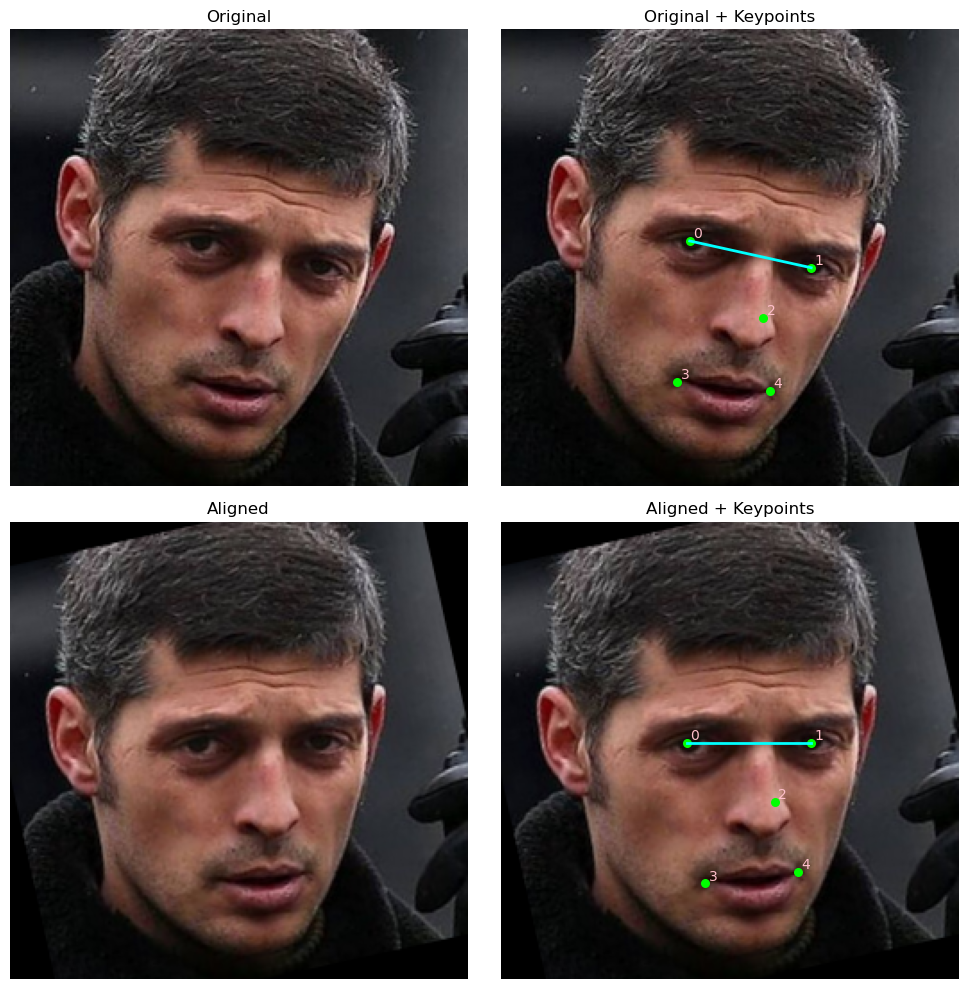

Aligned image saved to: givi_aligned.png


In [258]:
align_face_and_plot("givi.png", model)